# 프로젝트 : 2019 2nd ML month with KaKR

# Step1. 데이터 불러오기

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import missingno as msno

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/캐글 데이터/집값/train.csv')
test = pd.read_csv('/content/drive/MyDrive/캐글 데이터/집값/test.csv')
print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


# Step2. 데이터 이해하기
불러온데이터에 어떤 feature들이있는지 확인해보겠습니다. 그리고 해당 feature들에대한 의미는 사전에 공개되어있습니다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [ ]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


훈련데이터와 테스트데이터의 차이는 price컬럼하나인것으로 확인됩니다. 여기서 price컬럼은 정답레이블로 사용할것이기때문에 따로 y변수에 저장해두고 훈련데이터에서는 지워줍니다.

In [ ]:
y = train['price']
del train['price']

모델을 학습시키기전에, 전체데이터에 대해 탐색해보기위해 두 데이터를합쳐봅시다. 그리고 학습을 진행할때는 다시 분리해서 사용해야하기때문에 훈련데이터 총개수를 변수에 저장해두었다가 추후에 학습데이터만 불러올때 사용하겠습니다. 

In [ ]:
train_len = len(train)
data = pd.concat((train, test), axis=0)
data.shape

(21503, 20)

# Step3. 전처리
먼저 데이터에 결측치가 있는지 간단하게 눈으로 확인해보겠습니다.

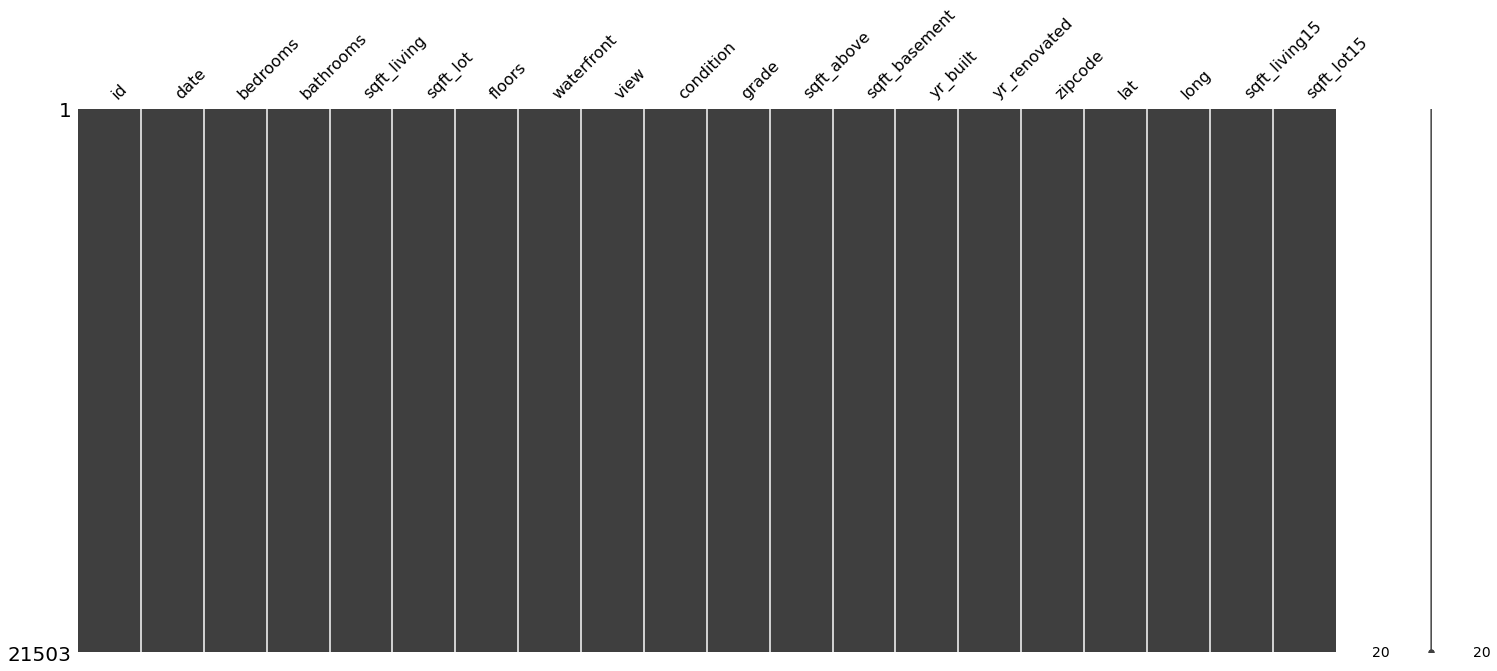

In [ ]:
msno.matrix(data)

결측치가 있다면 해당부분이 하얗게나옵니다 하지만 눈으로보기엔 해당 행렬에서는 보이지않습니다.
한번 자세히 들여다봅시다.

In [ ]:
for a in data.columns:
  print('{} : {}'.format(a, len(data.loc[pd.isnull(data[a]), a].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


이로써, 모든데이터에 결측치가 없는것을 확인했습니다.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

여기서 id는 집값을 예측하는데 필요없는 정보로 판단되므로 제거해주고, date는 날짜데이터인데, 첫8글자를 이용하도록 하겠습니다. 

그리고 나중에 예측 결과를 제출할 때를 대비하여 test_id변수에 id컬럼을 저장해두도록하겠습니다.

In [ ]:
test_id = data['id'][train_len:]
del data['id']

In [ ]:
data['date'] = data['date'].apply(lambda x : int(x[:8]) ).astype(int)

이제 각 컬럼들간의 상관관계를 확인해봅시다. 상관관계가 높다는 의미는 서로 비슷한 증가와 감소를 보인다는 것입니다. 이는 훈련시간만 증가시키기 때문에, 상관계수가 0.7이상인 데이터는 드랍시켜주도록하겠습니다.

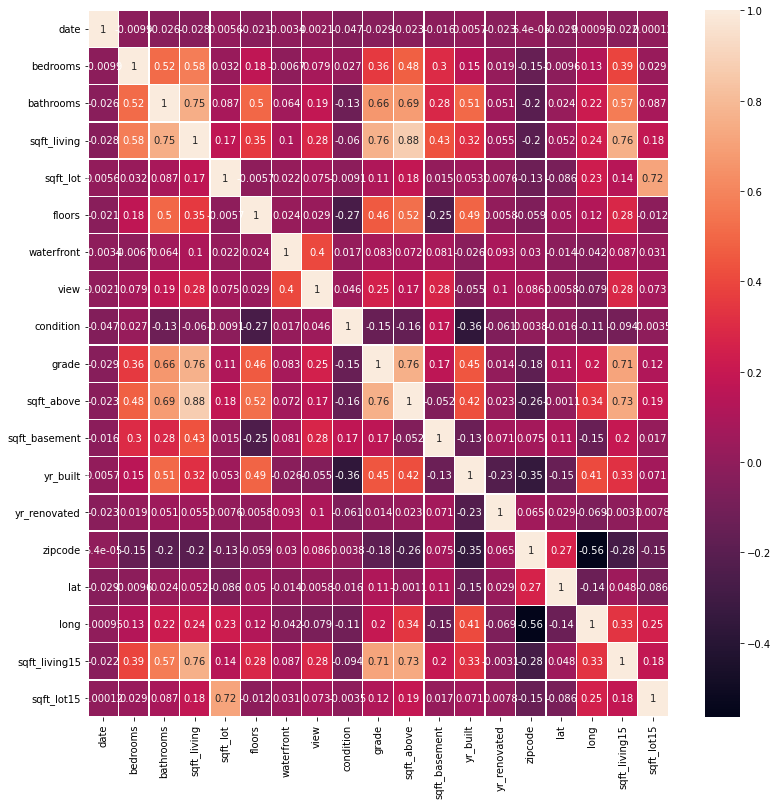

In [ ]:
plt.figure(figsize=(13,13))
sns.heatmap(data=data.corr(), annot = True, linewidths=0.3)


**sqft_living(주거공간의 평방피트)**는 grade(집의등급)과는 0.76, sqft_above(지하실을제외한 평방피트)와는 0.88, sqft_living15와는 0.76 의 상관계수를 가집니다.

**sqft_lot(부지의 평방피트)**는 sqft_lot15와 0.72의 상관계수를 가집니다.

따라서 드랍시켜줄 features는 grade, sqft_above, sqft_living, sqft_lot15로 총 4개입니다.

In [ ]:
data.drop(columns = ['grade','sqft_above','sqft_living','sqft_lot15'], inplace=True)

In [ ]:
data.shape

(21503, 15)

이제 전체 데이터들의 분포를 확인해봅시다.

특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는데에 좋지 않은 영향을 미치므로 다듬는 작업을 합니다.

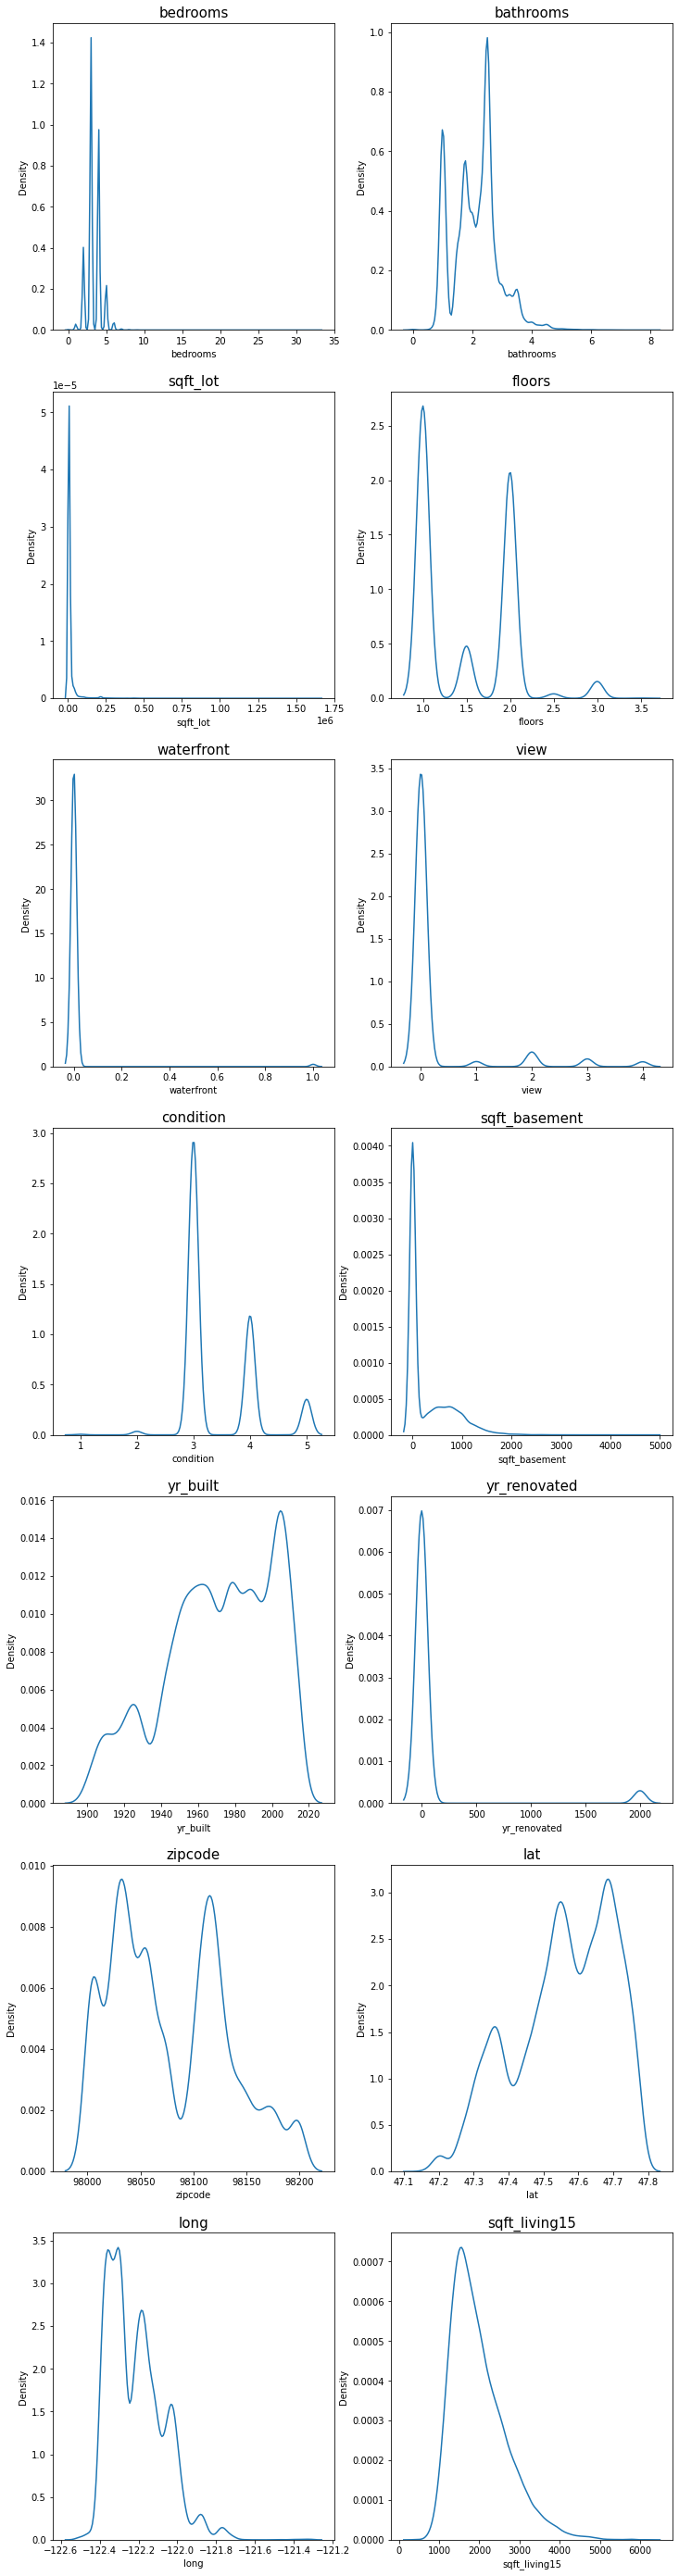

In [ ]:
fig, ax = plt.subplots(7, 2, figsize=(12, 50))

# date 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 15 :
            break


위 그래프 중에서 bedrooms, sqft_lot, sqft_basement, sqft_living15 컬럼이 한쪽으로 치우친 경향을 보이는것 같습니다. 이렇게 한쪽으로 치우친 분포의 경우에는 로그변환을 통해 데이터분포를 정규분포와 비슷하게 만들 수 있습니다.

In [ ]:
skew_columns = ['bedrooms', 'sqft_lot', 'sqft_basement', 'sqft_living15']

for a in skew_columns:
  data[a] = np.log1p(data[a].values)

한번 시각화해보고, 치우침이 줄어들었는지 확인해봅시다.

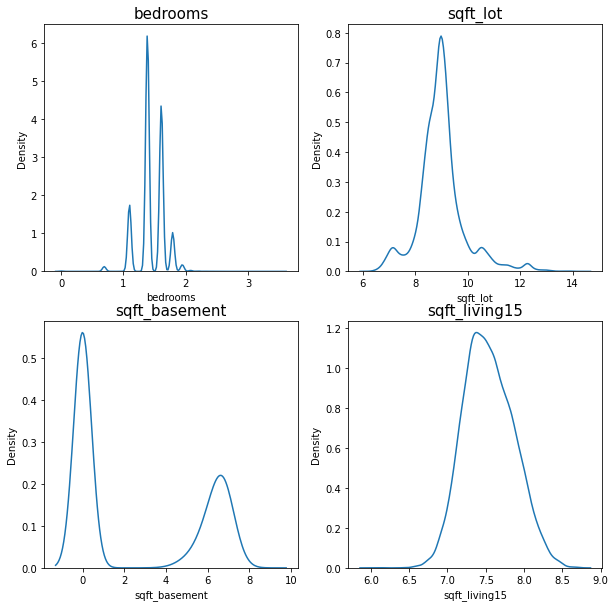

In [ ]:
fig , ax = plt.subplots(2,2, figsize=(10, 10))

count = 0
for row in range(2):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

아래와 같이 다시 전체데이터를 훈련과 테스트셋으로 나누어줍니다.

In [ ]:
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)

(15035, 15)
(6468, 15)


훈련셋과 테스트셋은 전부 준비가되었고, 마지막으로 타겟데이터인 y의 분포도 확인해보겠습니다.

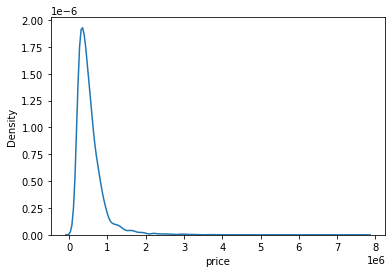

In [ ]:
sns.kdeplot(y)
plt.show()

앞서 살펴봤듯이 타겟레이블도 왼쪽으로 크게 치우쳐있는 형태를 보입니다. 로그변환을 통해 치우침을 줄여보겠습니다. 그리고 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리겠습니다. 

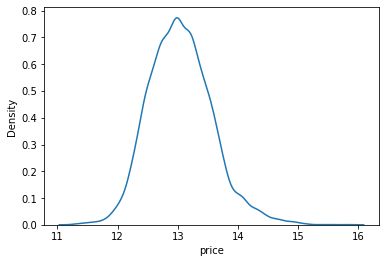

In [ ]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

치우침이 많이 줄어든것을 볼 수 있습니다.

# Step4. 훈련셋과 테스트셋 분리

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state = 2022)
X_train.shape, X_test.shape

((11276, 15), (3759, 15))

# Step5. 필요한 함수 구현
여러가지 반복되는 작업들은 함수로 먼저 만들어 놓고 훈련과 평가를 진행하겠습니다.

대회에서 점수를 매기는것과 같은 평가 척도인 RMSE를 계산하기위해 다음과 같은함수를 만들어놓겠습니다. 주의할점은 y_test나 y_pred는 위에서 np.log1p로 변환된 값이기 때문에 원래 데이터의 단위에 맞게 돌리기위해 np.expm1을 추가해야한다는 점입니다.

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

다음 네가지 모델을 임포트하겠습니다.

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

아래와 같이 모델 인스턴스를 생성후 models라는 리스트에 넣어줍니다.

In [ ]:
gboost = GradientBoostingRegressor(random_state=2022)
xgboost = XGBRegressor(random_state=2022)
lightgbm = LGBMRegressor(random_state=2022)
rdforest = RandomForestRegressor(random_state=2022)

models = [gboost, xgboost, lightgbm, rdforest]

다음과같은 for문으로 모델별 학습및 예측을 할수있습니다.

In [ ]:
df = {}

for model in models:
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    df[model_name] = rmse(y_test, y_pred)

    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[14:22:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 163009.7165372065,
 'LGBMRegressor': 148172.30365573833,
 'RandomForestRegressor': 166764.81287585146,
 'XGBRegressor': 166415.03665333273}

위 과정을 하나의 함수로 만들어보겠습니다.

In [ ]:
def get_scores(models):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)

        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models)

[14:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
RandomForestRegressor,166764.812876
XGBRegressor,166415.036653
GradientBoostingRegressor,163009.716537
LGBMRegressor,148172.303656


get_scores()함수는 모델리스트를 인수로받고 RMSE점수를 출력해줍니다.

# Step6. 하이퍼파라미너 튜닝
이제 다양한 하이퍼 파라미터로 평가해봅시다.
수행은 GridSearchCV클래스를 활용합니다.

In [ ]:
from sklearn.model_selection import GridSearchCV

먼저 LightGBM관련 하이퍼 파라미터를 튜닝해봅시다.

In [ ]:
param_grid = {
    'n_estimators': [900, 1000, 1100],
    'max_depth': [10, 100, 500],
    'learning_rate': [0.05, 0.07, 0.1]
}

그다음 모델을 준비합니다. 모델은 LightGBM을 사용해봅시다.

In [ ]:
model = LGBMRegressor(random_state=2022)

다음과같이 GridSearchCV를 이용해서 모든 하이퍼파라미터의 조합에대해 준비해봅시다.

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2022), n_jobs=5,
             param_grid={'learning_rate': [0.05, 0.07, 0.1],
                         'max_depth': [10, 100, 500],
                         'n_estimators': [900, 1000, 1100]},
             scoring='neg_mean_squared_error', verbose=1)

훈련에대한 결과는 grid_model.cv_results_안에 저장됩니다. 여기서 우리가 원하는값만 정제해서 보겠습니다. 파라미터 조합은 딕셔너리중 params에, 각 테스트에대한 점수는 mean_test_score에 저장되어있습니다.

In [ ]:
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 900},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000},
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1100},
 {'learning_rate': 0.05, 'max_depth': 100, 'n_estimators': 900},
 {'learning_rate': 0.05, 'max_depth': 100, 'n_estimators': 1000},
 {'learning_rate': 0.05, 'max_depth': 100, 'n_estimators': 1100},
 {'learning_rate': 0.05, 'max_depth': 500, 'n_estimators': 900},
 {'learning_rate': 0.05, 'max_depth': 500, 'n_estimators': 1000},
 {'learning_rate': 0.05, 'max_depth': 500, 'n_estimators': 1100},
 {'learning_rate': 0.07, 'max_depth': 10, 'n_estimators': 900},
 {'learning_rate': 0.07, 'max_depth': 10, 'n_estimators': 1000},
 {'learning_rate': 0.07, 'max_depth': 10, 'n_estimators': 1100},
 {'learning_rate': 0.07, 'max_depth': 100, 'n_estimators': 900},
 {'learning_rate': 0.07, 'max_depth': 100, 'n_estimators': 1000},
 {'learning_rate': 0.07, 'max_depth': 100, 'n_estimators': 1100},
 {'learning_rate': 0.

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.03429468, -0.03434594, -0.03437571, -0.03410945, -0.03416768,
       -0.03422706, -0.03410945, -0.03416768, -0.03422706, -0.03451741,
       -0.03459359, -0.03465565, -0.0345732 , -0.03464505, -0.03471738,
       -0.0345732 , -0.03464505, -0.03471738, -0.03485747, -0.03498342,
       -0.03507185, -0.03499083, -0.0351087 , -0.03521814, -0.03499083,
       -0.0351087 , -0.03521814])

해당 결과를 정리해서 데이터 프레임으로 확인해봅시다.

In [ ]:
results = pd.DataFrame(params)
results['score'] = score
results

,learning_rate,max_depth,n_estimators,score
0,0.05,10,900,-0.034295
1,0.05,10,1000,-0.034346
2,0.05,10,1100,-0.034376
3,0.05,100,900,-0.034109
4,0.05,100,1000,-0.034168
5,0.05,100,1100,-0.034227
6,0.05,500,900,-0.034109
7,0.05,500,1000,-0.034168
8,0.05,500,1100,-0.034227
9,0.07,10,900,-0.034517


해당점수는 neg_mean_squared_error를 사용했기때문에 RMSLE점수로 확인해보겠습니다.

In [ ]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.05,10,900,-0.034295,0.185188
1,0.05,10,1000,-0.034346,0.185327
2,0.05,10,1100,-0.034376,0.185407
3,0.05,100,900,-0.034109,0.184687
4,0.05,100,1000,-0.034168,0.184845
5,0.05,100,1100,-0.034227,0.185006
6,0.05,500,900,-0.034109,0.184687
7,0.05,500,1000,-0.034168,0.184845
8,0.05,500,1100,-0.034227,0.185006
9,0.07,10,900,-0.034517,0.185789


이제 마지막으로 할일은 RMSLE가 낮은 순서대로 정렬하는것 뿐입니다.

In [ ]:
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.05,100,900,-0.034109,0.184687
6,0.05,500,900,-0.034109,0.184687
4,0.05,100,1000,-0.034168,0.184845
7,0.05,500,1000,-0.034168,0.184845
5,0.05,100,1100,-0.034227,0.185006
8,0.05,500,1100,-0.034227,0.185006
0,0.05,10,900,-0.034295,0.185188
1,0.05,10,1000,-0.034346,0.185327
2,0.05,10,1100,-0.034376,0.185407
9,0.07,10,900,-0.034517,0.185789


결론적으로 가장 좋은 조합은 learning_rate=0.05, max_depth=100, n_estimators=900 입니다.
이제 해당모델로 학습을 해서 예측값인 submission.csv파일을 만들어서 제출해보겠습니다.

In [ ]:
model = LGBMRegressor(learning_rate=0.05, max_depth=100, n_estimators=900, random_state=2022)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.22833454, 13.11375121, 14.06264491, ..., 13.09769089,
       12.69685017, 12.79430331])

예측 결과에 np.expm1()을 씌워서 원래 스케일로 되돌려봅시다.

In [ ]:
prediction = np.expm1(prediction)
prediction

array([ 555893.90533788,  495711.40315644, 1280350.11341358, ...,
        487813.69445442,  326716.17662298,  360158.87353635])

# Step7. 제출
이제 최종적으로 submission.csv를 만들어봅시다.

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/캐글 데이터/집값/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우면 제출할 데이터가 완성됩니다.

In [ ]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.558939e+05
1,15036,4.957114e+05
2,15037,1.280350e+06
3,15038,2.824137e+05
4,15039,3.705475e+05


이 데이터를 csv파일로 저장하겠습니다.

In [ ]:
data_dir = '/content/drive/MyDrive/캐글 데이터/집값'
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.184687')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/캐글 데이터/집값/submission_lgbm_RMSLE_0.184687.csv


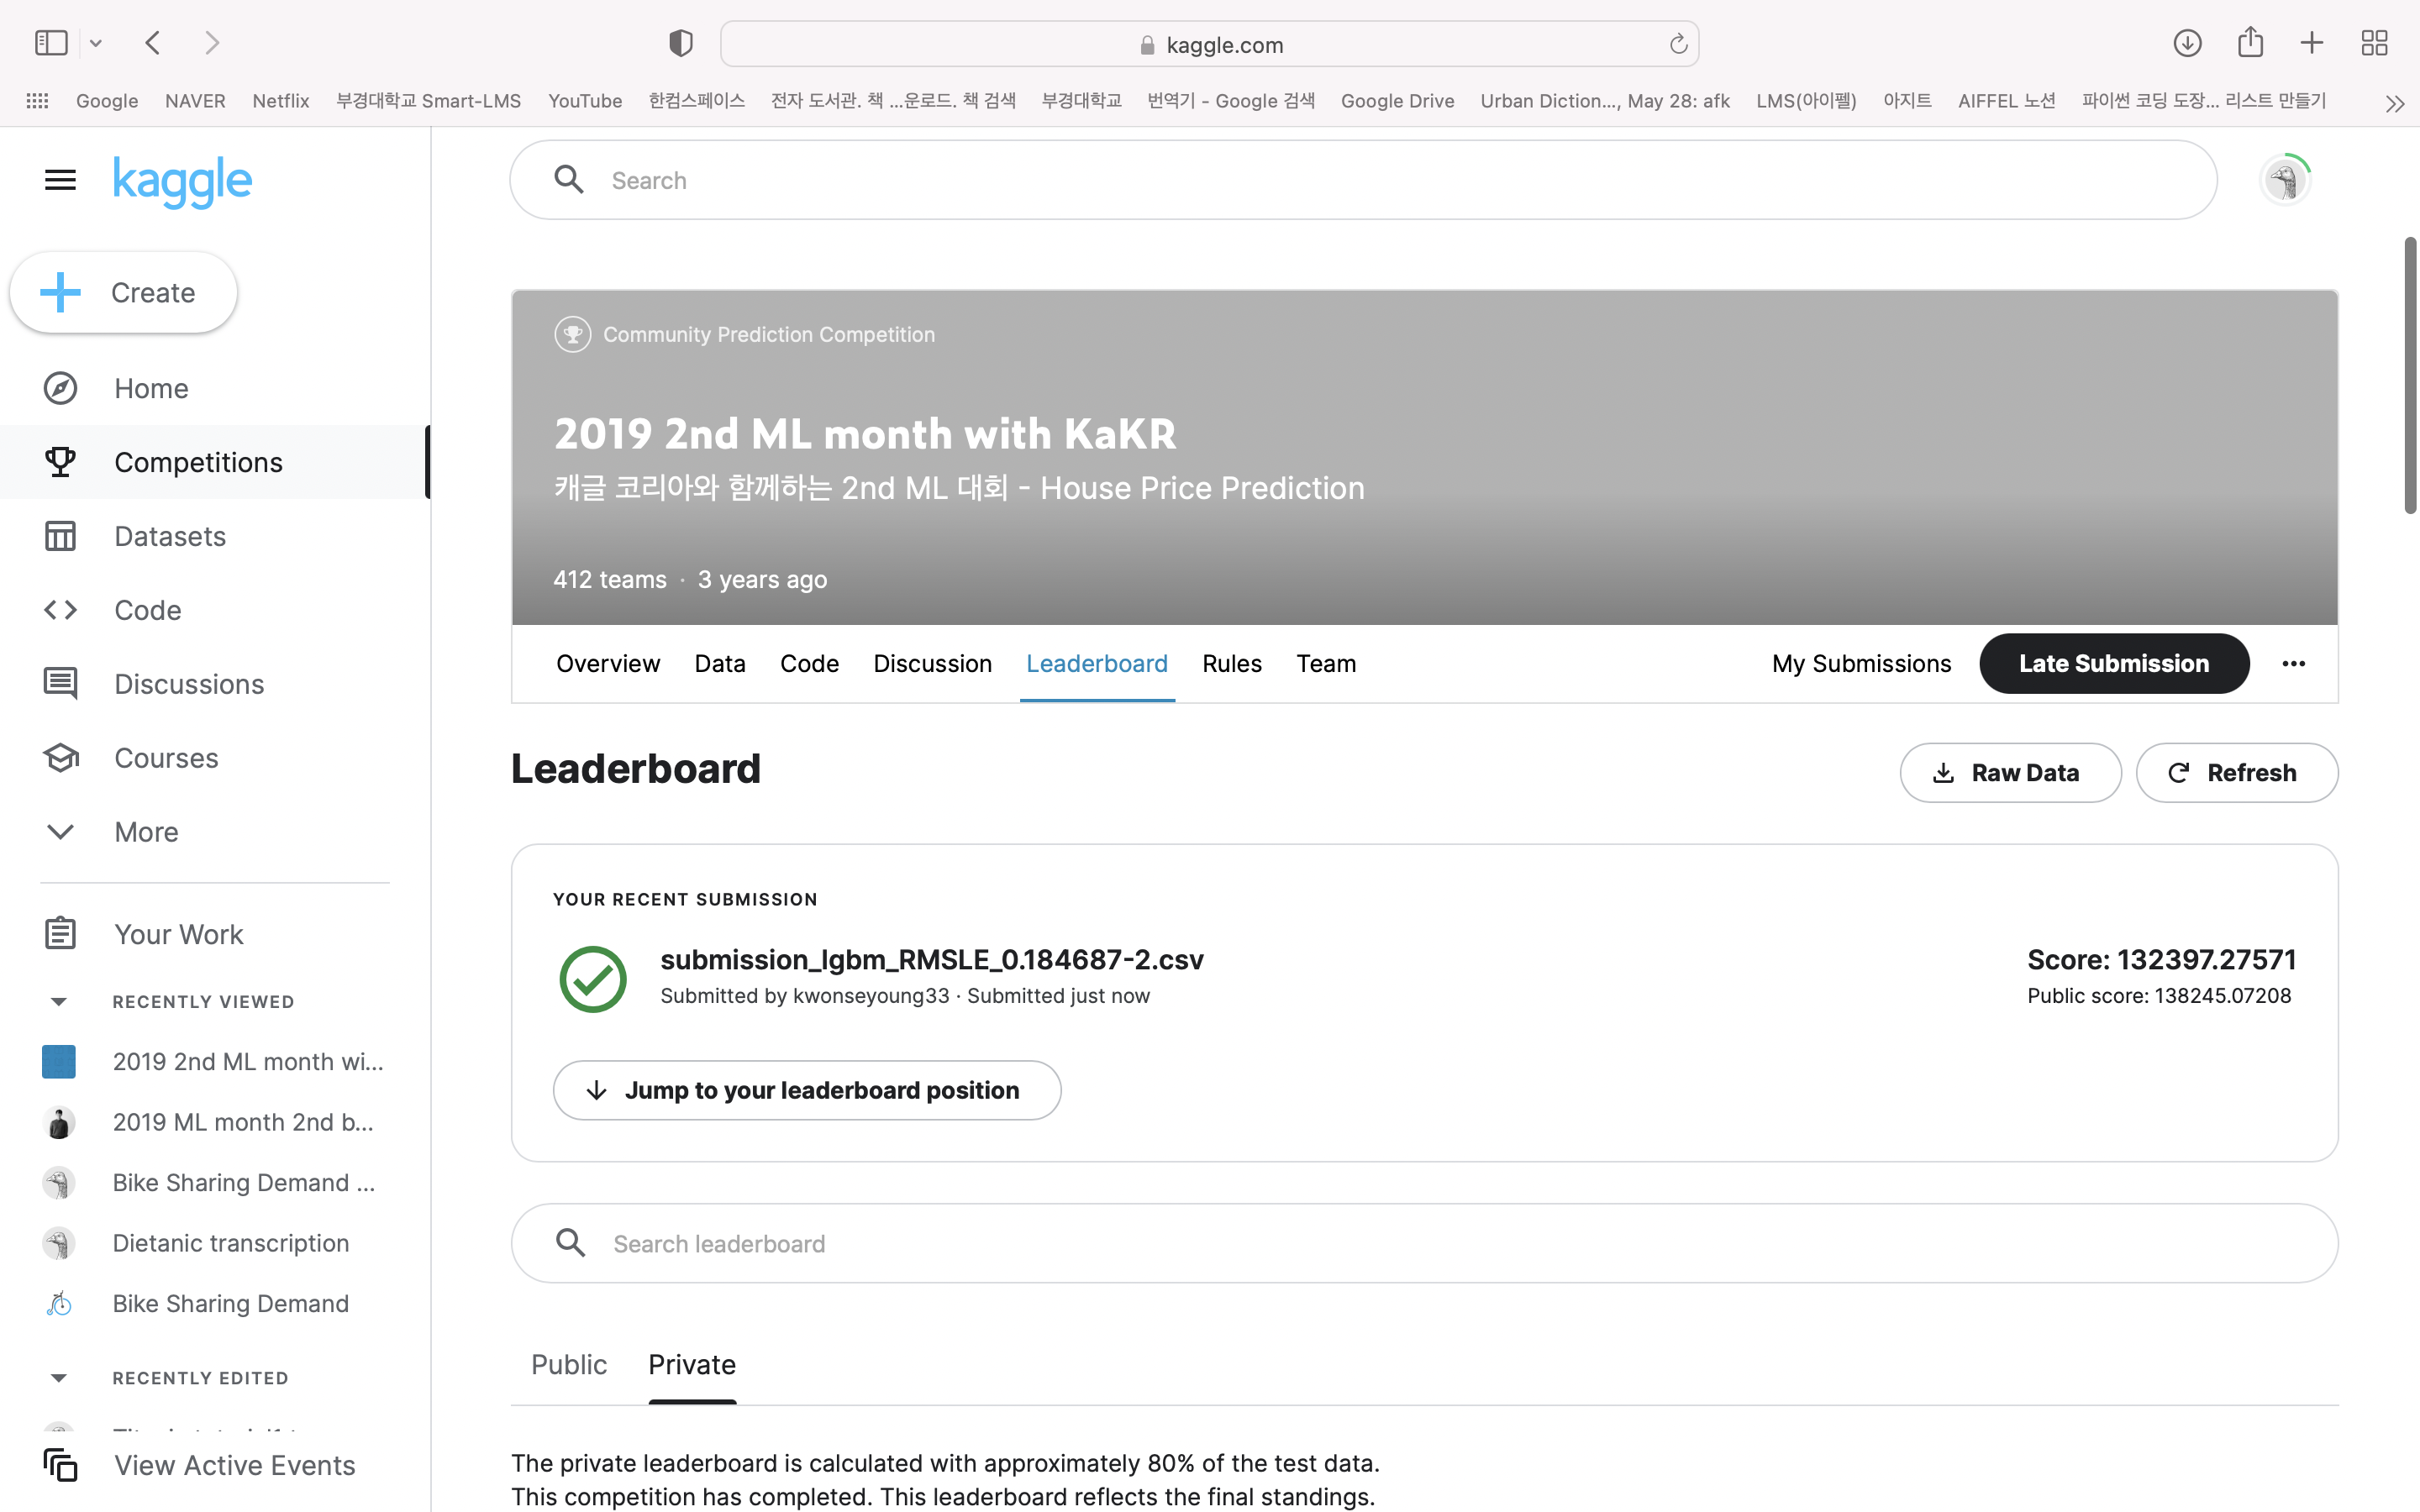

# 회고
이 프로젝트는 부동산데이터를 이용해 집값을 예측하는것입니다. 해당프로젝트를 진행하면서 전처리과정에서 새로알게된 개념은 한쪽으로 치우친분포를 로그변환을 통해서 정규분포와 비슷하게 바꿔준다는것이다. 다른 프로젝트나 캐글 필사를 진행하면서 로그변환을 통해 치우침을 줄이는 방식은 몇번 본적이있지만, 사실 정확하게 왜 그런지는 이해하지못하고 넘어갔었다. 하지만 이번에는 구글링을 통해 자세하게 알아본결과 로그함수는 x축1미만에서 굉장히 큰폭으로 줄어들고 숫자가 커질수록 늘어나는폭이 많이 줄어들기때문에, 치우침을 줄여준다는것이었다.

그리고 제일 중요한부분인 하이퍼파라미터 튜닝에대해서 진행해보았다. 해당 부분을 공부하면서 그리드서치에 대한 함수도 써보고, 여러모델중에서도 LightGBM모델의 하이퍼파라미터를 튜닝해보았다. 노드에 나와있는것말고도 다른 하이퍼파라미터를 찾아보면서 LightGBM모델을 좀더 자세히 알게되었고, 다양한 조합의 하이퍼파라미터의 결과를 보면서 최적의 조합도 그리드서치를 통해서 알게되었다. 따라서 모델을 훈련시킬때 하이퍼파라미터의 중요성도 같이 알게되는 시간이었다.

점수가 130000점이상이 나왔는데 이는 전처리과정에서 내멋대로 feature들을 건드린 잘못인것같다..각 feature들간의 상관계수를 보고 0.7이상인 feature들은 필요없다고생각해서 드랍시켜주었는데, 내 생각이랑 달리 feature를 드랍시킬때 상관계수이외에 다른 요건도 봐야하는것 같다. 나름 구글링을 해보았지만 아직 내수준에서 이해하기는 어려웠다..

해당데이터를 가지고 캐글에 처음 제출해보기도했는데, 이 과정으로 캐글데이터를받고, 결과를 제출하고 그에대한 점수도 확인하는 전반적인 진행과정을 배웠다.